In [ ]:
import numpy as np
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from pandas_profiling import ProfileReport

import joblib

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive
%ls

folder_path = "/content/drive/MyDrive/DFS"

Mounted at /content/drive/
/content/drive
MyDrive/


In [ ]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.6 MB/s eta 0:00:00


In [ ]:
!pip install biopython --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from Bio import SeqIO
for sequence in SeqIO.parse(os.path.join(folder_path,"example_dna.fa"),"fasta"):
    print(sequence.id)
    print(sequence.seq)
    print(len(sequence))

ENST00000435737.5
ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAATTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCCTTCTCCAAATTTTATGAGCAGTCTGTTGTTGCAGATGTCAGCAACAACAAAGGCGGCCTCCTTGTCCACTTTTGGATTGTTTTTGTCATGCCACGTGCCAAAGGCCACATCTTCTGTGAAGACTGTGTTGCCGCCATCTTGAAGGACTCCATCCAGACAAGCATCATAAACCGGACCTCTGTGGGGAGCTTGCAGGGACTGGCTGTGGACATGGACTCTGTGGTACTAAATGAAGTCCTGGGGCTGACTCTCATTGTCTGGATTGACTGA
390
ENST00000419127.5
ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAATTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCCTTCTCCAAATTTTATGAGCAGTCTGTTGTTGCAGATGTCAGCAACAACAAAGGCGGCCTCCTTGTCCACTTTTGGATTGTTTTTGTCATGCCACGTGCCAAAGGCCACATCTTCTGTGAAGACTGTGTTGCCGCCATCTTGAAGGACTCCATCCAGACAAGCATCATAAACCGGACCTCTGTGGGGAGCTTGCAGGGACTGGCTGTGGACATGGACTCTGTGGTACTAAATGACAAAGGCTGCTCTCAGTACTTCTATGCAGAGCATCTGTCTCTCCACTACCCGCTGGAGATTTCTGCAGCCTCAGGGAGGCTGATGTGTCACTTCAAGCTGGTGGCCATAGTGGGCTACCTGATTCGTCTCTCAATCAAGTCCATCCAAATCGAAGCCGACAACTGTGTCACTGACTCCCTGACCATTTACGACTCCCTTTTGCCCATCCGGAGCAG

In [ ]:
def string_to_array(seq_string):
   seq_string = seq_string.lower()
   seq_string = re.sub('[^acgt]', 'n', seq_string)
   seq_string = np.array(list(seq_string))
   return seq_string
# create a label encoder with 'acgtn' alphabet
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

LabelEncoder()

In [ ]:
def ordinal_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25 # A
    float_encoded[float_encoded == 1] = 0.50 # C
    float_encoded[float_encoded == 2] = 0.75 # G
    float_encoded[float_encoded == 3] = 1.00 # T
    float_encoded[float_encoded == 4] = 0.00 # anything else, lets say n
    return float_encoded


#Let’s try it out a simple short sequence:
seq_test = 'TTCAGCCAGTG'
ordinal_encoder(string_to_array(seq_test))

array([1.  , 1.  , 0.5 , 0.25, 0.75, 0.5 , 0.5 , 0.25, 0.75, 1.  , 0.75])

In [ ]:
def one_hot_encoder(seq_string):
    int_encoded = label_encoder.transform(seq_string)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    int_encoded = int_encoded.reshape(len(int_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(int_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded


#So let’s try it out with a simple short sequence:
seq_test = 'GAATTCTCGAA'
one_hot_encoder(string_to_array(seq_test))


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0]])

In [ ]:
def Kmers_funct(seq, size):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]


#So let’s try it out with a simple sequence:
mySeq = 'GTGCCCAGGTTCAGTGAGTGACACAGGCAG'
Kmers_funct(mySeq, size=7)

['gtgccca',
 'tgcccag',
 'gcccagg',
 'cccaggt',
 'ccaggtt',
 'caggttc',
 'aggttca',
 'ggttcag',
 'gttcagt',
 'ttcagtg',
 'tcagtga',
 'cagtgag',
 'agtgagt',
 'gtgagtg',
 'tgagtga',
 'gagtgac',
 'agtgaca',
 'gtgacac',
 'tgacaca',
 'gacacag',
 'acacagg',
 'cacaggc',
 'acaggca',
 'caggcag']

In [ ]:
words = Kmers_funct(mySeq, size=6)
joined_sentence = ' '.join(words)
joined_sentence

'gtgccc tgccca gcccag cccagg ccaggt caggtt aggttc ggttca gttcag ttcagt tcagtg cagtga agtgag gtgagt tgagtg gagtga agtgac gtgaca tgacac gacaca acacag cacagg acaggc caggca aggcag'

In [ ]:
mySeq1 = 'TCTCACACATGTGCCAATCACTGTCACCC'
mySeq2 = 'GTGCCCAGGTTCAGTGAGTGACACAGGCAG'
sentence1 = ' '.join(Kmers_funct(mySeq1, size=6))
sentence2 = ' '.join(Kmers_funct(mySeq2, size=6))

In [ ]:
#Creating the Bag of Words model:

cv = CountVectorizer()
X = cv.fit_transform([joined_sentence, sentence1, sentence2]).toarray()
X

array([[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1]])

In [ ]:
human_dna = pd.read_table(os.path.join(folder_path,"human.txt"))
human_dna.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


Text(0.5, 1.0, 'Class distribution of Human DNA')

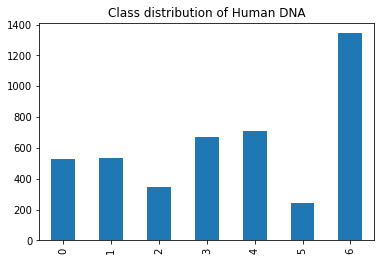

In [ ]:
human_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Human DNA")

In [ ]:
chimp_dna = pd.read_table(os.path.join(folder_path,"chimpanzee.txt"))
chimp_dna.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


Text(0.5, 1.0, 'Class distribution of Chimpanzee DNA')

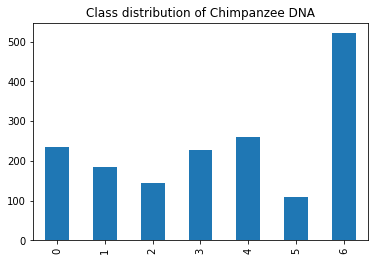

In [ ]:
chimp_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Chimpanzee DNA")

In [ ]:
dog_dna = pd.read_table(os.path.join(folder_path,"dog.txt"))
dog_dna.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


Text(0.5, 1.0, 'Class distribution of Dog DNA')

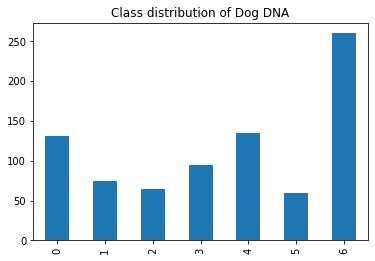

In [ ]:
dog_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Dog DNA")

In [ ]:
def Kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

#convert our training data sequences into short overlapping k-mers of length 6. 
#Lets do that for each species of data we have using our Kmers_funct function.

human_dna['words'] = human_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
human_dna = human_dna.drop('sequence', axis=1)

chimp_dna['words'] = chimp_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
chimp_dna = chimp_dna.drop('sequence', axis=1)

dog_dna['words'] = dog_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
dog_dna = dog_dna.drop('sequence', axis=1)

In [ ]:
human_dna.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [ ]:
human_texts = list(human_dna['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
#separate labels
y_human = human_dna.iloc[:, 0].values # y_human for human_dna

In [ ]:
chimp_texts = list(chimp_dna['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
#separate labels
y_chim = chimp_dna.iloc[:, 0].values # y_chim for chimp_dna

dog_texts = list(dog_dna['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
#separate labels
y_dog = dog_dna.iloc[:, 0].values  # y_dog for dog_dna

In [ ]:
y_human

array([4, 4, 3, ..., 6, 6, 6])

In [ ]:

cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [ ]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


In [ ]:
# Splitting the human dataset into the training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_human, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [ ]:
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)


MultinomialNB(alpha=0.1)

In [ ]:
!pip install joblib 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#filename = "DNA_Model_01"
#joblib.dump(classifier,filename)

In [ ]:
print(classifier)

MultinomialNB(alpha=0.1)


In [ ]:
#import joblib
#joblib.dump(classifier , '123')

In [ ]:
#import pickle

#with open('model_pkl', 'wb') as files:
    #pickle.dump(classifier, files)


In [ ]:
import pickle
from google.colab import drive

# Pickle model
with open('/content/drive/MyDrive/DFS/model.pickle', 'wb') as f:
    pickle.dump(classifier, f)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
print("Confusion matrix for predictions on human test DNA sequence\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on human test DNA sequence

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984


In [ ]:
# Predicting the chimp, dog sequences
y_pred_chimp = classifier.predict(X_chimp)

In [ ]:
# performance on chimpanzee genes
print("Confusion matrix for predictions on Chimpanzee test DNA sequence\n")
print(pd.crosstab(pd.Series(y_chim, name='Actual'), pd.Series(y_pred_chimp, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_chim, y_pred_chimp)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on Chimpanzee test DNA sequence

Predicted    0    1    2    3    4    5    6
Actual                                      
0          232    0    0    0    0    0    2
1            0  184    0    0    0    0    1
2            0    0  144    0    0    0    0
3            0    0    0  227    0    0    1
4            2    0    0    0  254    0    5
5            0    0    0    0    0  109    0
6            0    0    0    0    0    0  521
accuracy = 0.993 
precision = 0.994 
recall = 0.993 
f1 = 0.993


In [ ]:
y_pred_dog = classifier.predict(X_dog)

In [ ]:
# performance on dog genes
print("Confusion matrix for predictions on Dog test DNA sequence\n")
print(pd.crosstab(pd.Series(y_dog, name='Actual'), pd.Series(y_pred_dog, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred_dog)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on Dog test DNA sequence

Predicted    0   1   2   3    4   5    6
Actual                                  
0          127   0   0   0    0   0    4
1            0  63   0   0    1   0   11
2            0   0  49   0    1   0   14
3            1   0   0  81    2   0   11
4            4   0   0   1  126   0    4
5            4   0   0   0    1  53    2
6            0   0   0   0    0   0  260
accuracy = 0.926 
precision = 0.934 
recall = 0.926 
f1 = 0.925
